In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
import sqlite3
from astropy.time import Time
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_time_range(baseline):
    """
    Query the baseline database to get the observation time range.

    Parameters:
    baseline (str): Path to the baseline database file.

    Returns:
    tuple: Start and end MJD of observations.
    """
    conn = sqlite3.connect(baseline)
    cursor = conn.cursor()
    
    query = "SELECT MIN(observationStartMJD), MAX(observationStartMJD) FROM observations"
    cursor.execute(query)
    result = cursor.fetchone()
    
    conn.close()
    
    return result

baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
start_mjd, end_mjd = get_time_range(baseline)
start_date = Time(start_mjd, format='mjd').to_value('iso', subfmt='date')
end_date = Time(end_mjd, format='mjd').to_value('iso', subfmt='date')

# Calculate the difference in years
start_time = Time(start_mjd, format='mjd')
end_time = Time(end_mjd, format='mjd')
difference_in_years = (end_time - start_time).to('year')

print(f"Start MJD: {start_mjd}, End MJD: {end_mjd}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Difference in Years: {difference_in_years:.2f}")

Start MJD: 60796.00143922635, End MJD: 64448.42922491617
Start Date: 2025-05-01
End Date: 2035-05-01
Difference in Years: 10.00 yr


/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [4]:
def calculate_monthly_qso_numbers(baseline, nside, maps, outdir, ourdir_db, start_mjd):
    """
    Calculate monthly QSO numbers for different filters and redshifts.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.
    start_mjd (float): Start MJD of observations.

    Returns:
    dict: Dictionary of metric bundles for each filter, redshift, and month.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    annual_bundles = {month: {} for month in range(1, 121)}
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)

    for month in range(1,121):
        print(f"Processing month {month}...")
        for f in ('u', 'g', 'r', 'i', 'z', 'y'):
            metric = maf.QSONumberCountsMetric(f, zmax=6.7)
            month_start_mjd = start_mjd
            month_end_mjd = start_mjd + month * 30.44
            #sql = f'target_name not like "DD%" and filter = "{f}" and observationStartMJD >= {month_start_mjd} and observationStartMJD < {month_end_mjd}'
            sql = f'filter = "{f}" and observationStartMJD >= {month_start_mjd} and observationStartMJD < {month_end_mjd}'
            bundle = maf.MetricBundle(metric, slicer, sql, run_name=f'{run_name}_month{month}', maps_list=[dustmap], info_label=f'{f} band month {month}')
            annual_bundles[month][f] = bundle
        
        results_db = maf.db.ResultsDb(out_dir=os.path.join(ourdir_db, f'{run_name}_month{month}'))
        # Flatten the annual_bundles[month] dictionary for MetricBundleGroup
        bundle_group = maf.MetricBundleGroup(annual_bundles[month], baseline_file, out_dir=outdir, results_db=results_db)    
        bundle_group.run_all()
        
    return annual_bundles

In [5]:
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64
outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/Baseline_4_0'
ourdir_db = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/Baseline_4_0/MetricData/'

# Get the time range from the database
start_mjd, end_mjd = get_time_range(baseline)
print(f"Start MJD: {start_mjd}, End MJD: {end_mjd}")

# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

monthly_qso_numbers = calculate_monthly_qso_numbers(baseline, nside, maps, outdir, ourdir_db, start_mjd)

Start MJD: 60796.00143922635, End MJD: 64448.42922491617
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Processing month 1...
Processing month 2...
Processing month 3...
Processing month 4...
Processing month 5...
Processing month 6...
Processing month 7...
Processing month 8...
Processing month 9...
Processing month 10...
Processing month 11...
Processing month 12...
Processing month 13...
Processing month 14...
Processing month 15...
Processing month 16...
Processing month 17...
Processing month 18...
Processing month 19...
Processing month 20...
Processing month 21...
Processing month 22...
Processing month 23...
Processing month 24...
Processing month 25...
Processing month 26...
Processing month 27...
Processing month 28...
Processing month 29...
Processing month 30...
Processing month 31...
Processing month 32...
Processing month 33...
Processing month 34...
Processing month 35...
Processing month 36...
Processing month 37...
Processing month 38...
Pro

In [ ]:
from rubin_sim.maf import MetricBundle, MetricBundleGroup

def calculate_total_qsos_band(bundle):
    """
    Calculate the total number of QSOs for a given metric bundle.
    
    Parameters:
    bundle (MetricBundle): The metric bundle to calculate QSOs from.
    
    Returns:
    float: The total number of QSOs.
    """
    summary = maf.SumMetric(col='metric')
    bundle.set_summary_metrics([summary])
    bundle.compute_summary_stats()
    total_qsos = bundle.summary_values[summary.name]
    return total_qsos

def extract_qso_data(npz_file):
    """Extract QSO data from a .npz file."""
    bundle = MetricBundle.load(npz_file)
    total_qso = calculate_total_qsos_band(bundle)
    return int(total_qso)

def create_qso_csv_files(result_dir, output_dir, filters, months):
    
    df = pd.DataFrame(index=[f"{f}" for f in filters], columns=months)
    
    """Create CSV files with QSO counts for each filter and year."""
    for f in filters:
        for month in months:
            npz_file = os.path.join(result_dir, f"baseline_v4_0_10yrs_month{month}_QSONumberCountsMetric_{f}_band_month_{month}_HEAL.npz")
                
            if os.path.exists(npz_file):
                qso_counts = extract_qso_data(npz_file)
                # Assuming qso_counts is an array of QSO numbers, you might need to adjust this if it's a different structure
                df.at[f"{f}", month] = qso_counts
            else:
                df.at[f"{f}", month] = np.nan
        # Save DataFrame to CSV
    csv_file = os.path.join(output_dir, f"QSO_counts.csv")
    df.to_csv(csv_file)
    print(f"Saved QSO counts to {csv_file}")

# Parameters
result_dir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/Baseline_4_0'          
output_dir = './' 
filters = ['u', 'g', 'r', 'i', 'z', 'y']
months = range(1, 121)

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate CSV files
create_qso_csv_files(result_dir, output_dir, filters, months)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

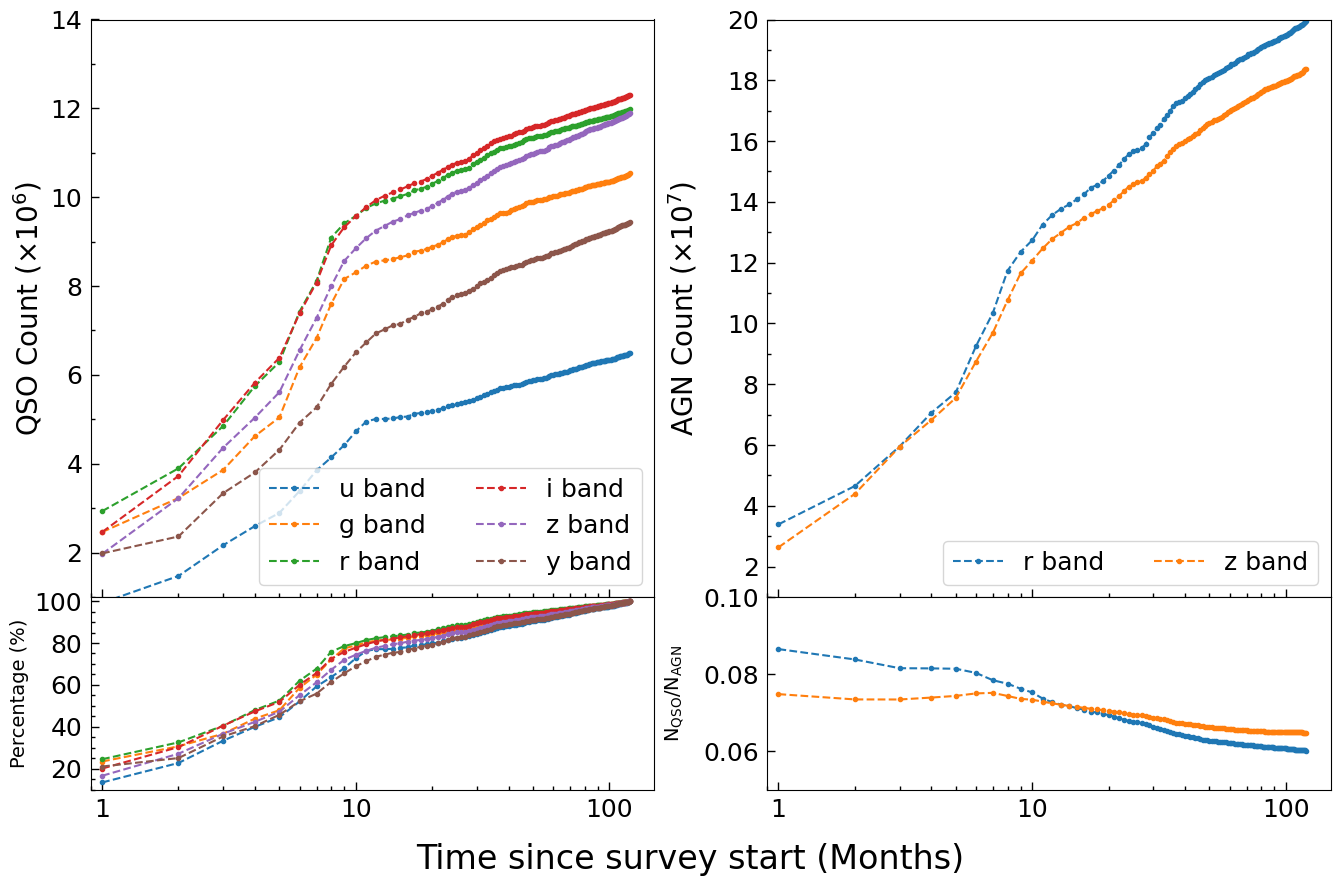

In [9]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def plot_qso_counts_over_months_percentage(ax, df):
    months = range(1, 121)
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    qso_counts = {f: [] for f in filters}
    dates = []

    # Extract QSO counts for each year and filter
    for month in months:
        for f in filters:
            qso_counts[f].append(df[str(month)][f])
    
    qso_percentage = {f: [(count / qso_counts[f][-1]) * 100 for count in qso_counts[f]] for f in filters}
    #fig = plt.figure(figsize=[9,6])
    #ax  = fig.add_subplot(111)
    for f in filters:
        ax.plot(months, qso_percentage[f], marker='o', linestyle='--', markersize=3, label=f+' band')

    ymajorLocator = MultipleLocator(20)
    yminorLocator = MultipleLocator(5)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    #ax.set_xlabel('Time since survey start (Months)',fontsize=20)
    ax.set_ylim(10,102)
    ax.set_ylabel(r'Percentage (%)',fontsize=14)
    #plt.title('QSO Counts Over 10 Years for Different Filters')
    #ax.legend(loc='lower right', ncol=2, fontsize=18)
    ax.set_xscale('log')
    #ax.grid(True)
    ax.set_xlim(0.9,150)
    xmajorFormatter = FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(xmajorFormatter)

def plot_qso_counts_over_months(ax, df):
    months = range(1, 121)
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    qso_counts = {f: [] for f in filters}
    dates = []
    
    # Extract QSO counts for each year and filter
    for month in months:
        for f in filters:
            qso_counts[f].append(df[str(month)][f])
            
    dict_t = {}
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/1e6, marker='o', linestyle='--',markersize=3, label=f'{f} band')

    ymajorLocator = MultipleLocator(2)
    yminorLocator = MultipleLocator(1)
    xmajorLocator = MultipleLocator(10)
    xminorLocator = MultipleLocator(2)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelbottom=False,labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    #ax.set_xlabel('Month',fontsize=24)
    ax.set_ylim(1,14)
    ax.set_ylabel(r'QSO Count ($\times 10^{6}$)',fontsize=20)
    #ax.grid(True)
    ax.set_xlim(0.9,150)
    ax.legend(loc='lower right', ncol=2, fontsize=18)
    ax.set_xscale('log')

def plot_N_AGN_QSO(ax, df, df2):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    AGN_counts = {f: [] for f in filters}
    dates = []

    for month in months:
        for f in filters:
            qso_counts[f].append(df2[str(month)][f])
            AGN_counts[f].append(df[str(month)][f])
    
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/np.array(AGN_counts[f]), marker='o', linestyle='--', markersize=3, label=f+' band')

    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    #ax.set_xlabel('Time since survey start (Months)',fontsize=20)
    ax.set_ylabel(r'$\rm N_{QSO}/N_{AGN}$',fontsize=14, labelpad=12)
    ax.set_xscale('log')
    ax.set_xlim(0.9,150)
    ax.set_ylim(0.05,0.10)
    xmajorFormatter = FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(xmajorFormatter)
    ymajorFormatter = FormatStrFormatter('%.2f')
    ax.yaxis.set_major_formatter(ymajorFormatter)

def plot_AGN_counts_over_months(ax, df):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    dates = []
    
    for month in months:
        for f in filters:
            qso_counts[f].append(df[str(month)][f])
            
    dict_t = {}
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/1e7, marker='o', linestyle='--',markersize=3, label=f'{f} band')

    ymajorLocator = MultipleLocator(2)
    yminorLocator = MultipleLocator(1)
    xmajorLocator = MultipleLocator(10)
    xminorLocator = MultipleLocator(2)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,labelbottom=False,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    #ax.set_xlabel('Month',fontsize=24)
    ax.set_ylim(1,20)
    ax.set_ylabel(r'AGN Count ($\times 10^{7}$)',fontsize=20, labelpad=20)
    ax.set_xlim(0.9,150)
    ax.legend(loc='lower right', ncol=2, fontsize=18)
    ax.set_xscale('log')
    
def combine(df, df2):

    fig, axs = plt.subplots(2, 2, figsize=(16, 10),
                            gridspec_kw={'height_ratios': [3, 1],  'hspace': 0} )
    #                        gridspec_kw={'wspace': 0, 'hspace': 0})
    axs = axs.flatten()
    plot_qso_counts_over_months(axs[0], df)
    plot_qso_counts_over_months_percentage(axs[2], df)
    plot_AGN_counts_over_months(axs[1], df2)
    plot_N_AGN_QSO(axs[3], df2, df)
    #plt.xticks(rotation=45)
    fig.text(0.5, 0.04, 'Time since survey start (Months)', ha='center', va='center', fontsize=24)
    plt.savefig('Figure4.png', dpi=300, bbox_inches='tight')
    plt.show()

df2 = pd.read_csv('AGN_month.csv',index_col=0)
df = pd.read_csv('QSO_counts.csv',index_col=0)
combine(df, df2)